In [1]:
%pylab inline
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import theano.tensor as tt
import theano
plt.style.use(['seaborn-talk'])
plt.rcParams["figure.figsize"] = (10,8)
print(pm.__version__)
print(theano.__version__)

Populating the interactive namespace from numpy and matplotlib


/home/deadhead/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


3.5
1.0.2


In [2]:
c_light ="#DCBCBC"
c_light_highlight ="#C79999"
c_mid ="#B97C7C"
c_mid_highlight ="#A25050"
c_dark ="#8F2727"
c_dark_highlight ="#7C0000"

In [28]:
class TruncatedZeroInflatedPoisson(pm.Discrete):

    def __init__(self, psi, theta, maximum, *args, **kwargs):
        super(TruncatedZeroInflatedPoisson, self).__init__(*args, **kwargs)
        self.theta = tt.as_tensor_variable(theta)
        self.psi = tt.as_tensor_variable(psi)
        self.maximum = tt.as_tensor_variable(maximum)
        self.pois = pm.Poisson.dist(theta)
        self.mode = self.pois.mode


    def random(self, point=None, size=None):
        theta, psi, maximum = pm.distributions.draw_values(
            [self.theta, self.psi, self.maximum], point=point, size=size)
        g = pm.distributions.generate_samples(stats.poisson.rvs, theta,
                             dist_shape=self.shape,
                             size=size)
        return np.minimum(g * (np.random.random(np.squeeze(g.shape)) < psi), maximum)


    def logp(self, value):
        theta = self.theta
        psi = self.psi
        maximum = self.maximum
        poisson = pm.Poisson.dist(theta)
        logp_val = tt.switch(
            tt.gt(value, 0),
            tt.log(psi) + poisson.logp(value),
            pm.math.logaddexp(tt.log1p(-psi), tt.log(psi) - theta))

        return pm.distributions.dist_math.bound(
            logp_val,
            0 <= value,
            value <= maximum,
            0 <= psi, psi <= 1,
            0 <= theta)

In [33]:
generative_ensemble4 = pm.Model()

N = 1000
R = 1000

with generative_ensemble4:
    theta = pm.Beta(name="theta", alpha = 2.8663, beta = 2.8663)
    lambda_ = pm.InverseGamma(name="lambda", alpha = 3.48681, beta = 9.21604)
    maximum = 14
    y = TruncatedZeroInflatedPoisson(name="y", theta=lambda_, psi = theta, maximum = maximum, shape =N)
    
    trace = pm.sample_prior_predictive(R)

In [34]:
simulated_lambdas = trace['lambda']
simulated_thetas = trace['theta']
simulated_ys = trace['y']

In [35]:
simulated_ys

array([[0, 0, 2, ..., 0, 0, 3],
       [0, 3, 1, ..., 0, 0, 2],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [3, 1, 2, ..., 7, 0, 0],
       [4, 2, 3, ..., 0, 0, 0]])

In [40]:
def plot_prior_predictive(simulated_ys):
    x_max = 30
    bins = np.arange(0,x_max)
    bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
    hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, simulated_ys)

    prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
    prctiles_interp = np.repeat(prctiles, 10,axis=1)
    for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
        plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);

    plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
    plt.axvline(x=25,ls='-',lw=2,color='k');
    plt.xlabel('y');
    plt.title('Prior predictive distribution');

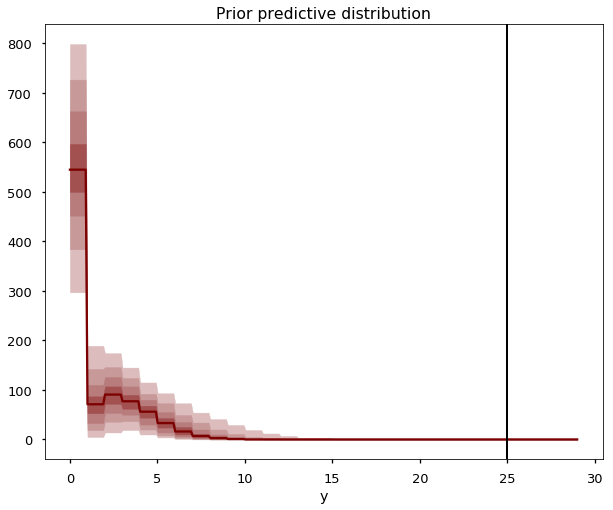

In [41]:
plot_prior_predictive(simulated_ys)

In [46]:
fit_data4 = pm.Model()

N = 1000
R = 1000

with fit_data4:
    theta = pm.Beta(name="theta", alpha = 2.8663, beta = 2.8663)
    lambda_ = pm.InverseGamma(name="lambda", alpha = 3.48681, beta = 9.21604)
    maximum = 14
    y = TruncatedZeroInflatedPoisson(name="y", 
                                     theta=lambda_, 
                                     psi = theta, 
                                     maximum = maximum, 
                                     shape = N,
                                     observed=simulated_ys[:,-1])
    
    trace_fit = pm.sample(R,tune=4 * R, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambda, theta]
Sampling 2 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2445.94draws/s]


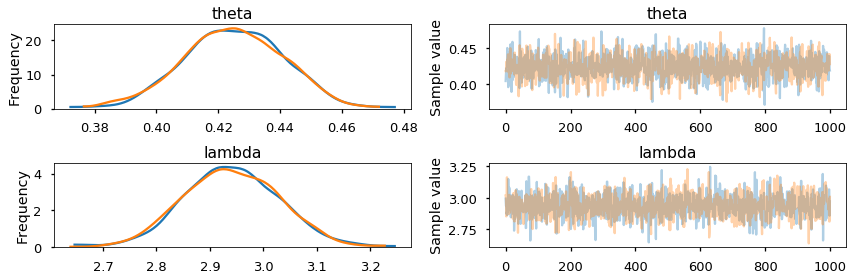

In [47]:
pm.plots.traceplot(trace_fit);

In [48]:
sbc_rank = np.sum(simulated_lambdas < trace_fit['lambda'][::2])

In [49]:
stat_summary = pm.stats.summary(trace_fit, varnames=['lambda'])
post_mean_lambda = stat_summary['mean'].values
post_sd_lambda = stat_summary['sd'].values
prior_sd_lambda = 6.44787
z_score = np.abs((post_mean_lambda - simulated_lambdas) / post_sd_lambda)
shrinkage = 1 - (post_sd_lambda / prior_sd_lambda ) ** 2

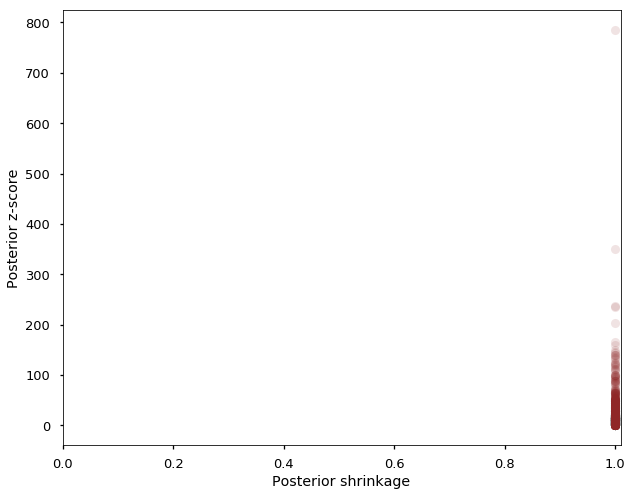

In [50]:
plt.plot(shrinkage[0] * np.ones(len(z_score)), z_score, 'o', c="#8F272720");
plt.xlim(0,1.01); 
plt.xlabel('Posterior shrinkage'); 
plt.ylabel('Posterior z-score');

## Fit observations and evaluate

In [52]:
df = pd.read_csv('data.csv')
data_ys = df[df['data']=='y']['value'].values

In [53]:
model = pm.Model()
with model:
    theta = pm.Beta(name="theta", alpha = 2.8663, beta = 2.8663)
    lambda_ = pm.InverseGamma(name="lambda", alpha = 3.48681, beta = 9.21604)
    maximum = 14
    y = TruncatedZeroInflatedPoisson(name="y", 
                                     theta=lambda_, 
                                     psi = theta, 
                                     maximum = maximum, 
                                     shape = N,
                                     observed = data_ys)
    
    trace = pm.sample(draws=R,tune=4 * R, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda, theta]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:06<00:00, 3170.14draws/s]


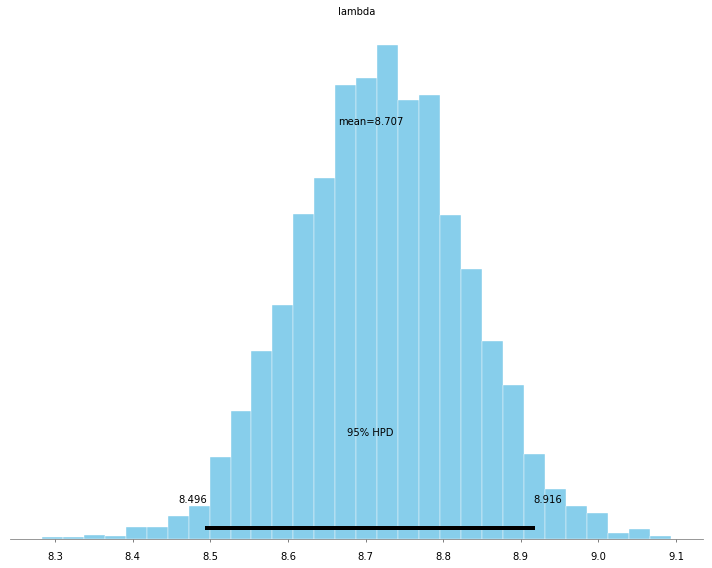

In [54]:
pm.plots.plot_posterior(trace, varnames=['lambda']);

In [55]:
with model:
     ppc = pm.sample_ppc(trace)

/home/deadhead/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 1000/1000 [00:00<00:00, 1718.60it/s]


In [56]:
x_max = 30
bins = np.arange(0,x_max)
bin_interp = np.linspace(0,x_max-1,num=(x_max-1)*10)
hists = np.apply_along_axis(lambda a: np.histogram(a, bins=bins)[0], 0, ppc['y'])

prctiles = np.percentile(hists,np.linspace(10,90,num=9),axis=1)
prctiles_interp = np.repeat(prctiles, 10,axis=1)

data_hist = np.histogram(data_ys,bins=bins)[0]
data_hist_interp = np.repeat(data_hist, 10)

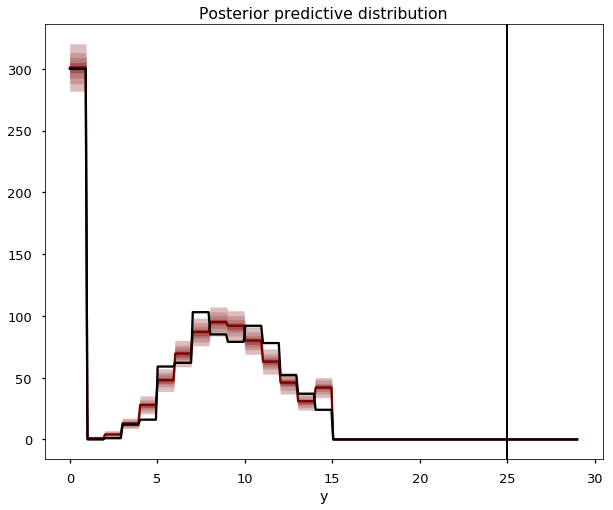

In [57]:
for i,color in enumerate([c_light,c_light_highlight,c_mid,c_mid_highlight]):
    plt.fill_between(bin_interp,prctiles_interp[i,:],prctiles_interp[-1-i,:],alpha=1.0,color=color);


plt.plot(bin_interp,prctiles_interp[4,:],color=c_dark_highlight);
plt.plot(bin_interp,data_hist_interp,color='black');
plt.axvline(x=25,ls='-',lw=2,color='k');
plt.xlabel('y');
plt.title('Posterior predictive distribution');